In [609]:
#Standard Packages:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from datetime import datetime
from dateutil.relativedelta import relativedelta
from pandas.tseries.offsets import MonthEnd
import matplotlib.pyplot as plt
import time
import seaborn as sns


#Statsmodels:
import statsmodels.api as sma
import statsmodels as sm
from statsmodels import tsa
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.stattools import jarque_bera
from scipy.stats import t, probplot

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
pd.options.mode.chained_assignment = None  # default='warn'
from sklearn.linear_model import LinearRegression
from pmdarima.arima.utils import ndiffs
from statsmodels.graphics.tsaplots import plot_acf

In [610]:
def difference(series, order=1):
    """
    Apply differencing to a time series.
    If order > 1, difference repeatedly order times.
    """
    diffed = series.copy()
    for _ in range(order):
        diffed = diffed.diff().dropna()
    return diffed

def invert_difference(last_original, differenced):
    """
    Invert a single differencing step.
    last_original is the last known observation before differencing.
    differenced is the differenced value to be inverted.
    """
    return last_original + differenced

def create_lag_features(series, p_lags, q_lags):
    """
    Create AR and MA features based on specific lists of lags.
    AR features: lagged values of the differenced series.
    MA features: lagged residuals (initialized as zeros and replaced after fitting).
    
    p_lags: list of AR lags (e.g. [1,3,5]) determined from PACF
    q_lags: list of MA lags (e.g. [2,4]) determined from ACF
    """
    # AR lags
    X_ar = pd.DataFrame(index=series.index)
    for lag in p_lags:
        X_ar[f'lag_{lag}'] = series.shift(lag)
    
    # MA lags - initially zero or NaN, will be filled after we get residuals
    X_ma = pd.DataFrame(index=series.index)
    for lag in q_lags:
        X_ma[f'ma_{lag}'] = 0
    
    # Combine AR and MA features
    if len(q_lags) > 0:
        X = pd.concat([X_ar, X_ma], axis=1)
    else:
        X = X_ar
    
    # Drop rows with NaN due to lagging
    X = X.dropna()
    y = series.loc[X.index]
    return X, y

def ARIMA(p, i, q, df):
    """
    Fit an ARIMA model to the given time series `df` using specified AR and MA lags.
    p: list of AR lags (from PACF significance)
    i: order of differencing
    q: list of MA lags (from ACF significance)
    df: Pandas Series of the time series values.
    
    Returns:
    model_dict: A dictionary containing the fitted model information.
    """
    # Ensure df is a series
    if not isinstance(df, pd.Series):
        df = pd.Series(df)
        
    original_series = df.copy()
    
    # Difference the series i times
    differenced_series = difference(df, order=i)
    
    # Create initial AR and placeholder MA features
    X, y = create_lag_features(differenced_series, p, q)
    
    # Initialize model
    model = LinearRegression()
    
    # If no MA terms, just fit once
    if len(q) == 0:
        model.fit(X, y)
        residuals = y - model.predict(X)
    else:
        # Step 1: Fit AR-only model
        ar_cols = [col for col in X.columns if col.startswith('lag_')]
        model.fit(X[ar_cols], y)
        residuals = y - model.predict(X[ar_cols])
        
        # Now fill in the MA features with lagged residuals
        for lag in q:
            X[f'ma_{lag}'] = residuals.shift(lag)
        
        # Drop rows with NaN after adding residuals
        combined = pd.concat([X, y], axis=1).dropna()
        X = combined[X.columns]
        y = combined[y.name]
        
        # Refit with AR+MA
        model.fit(X, y)
        residuals = y - model.predict(X)
        
    # Store model parameters
    coef = model.coef_
    intercept = model.intercept_
    
    # Determine how many historical values we need for forecasting
    # For AR, we need max(p); for MA, we need max(q)
    max_p = max(p) if len(p) > 0 else 0
    max_q = max(q) if len(q) > 0 else 0
    max_lag = max(max_p, max_q)
    
    model_dict = {
        'p': p,
        'i': i,
        'q': q,
        'model': model,
        'intercept': intercept,
        'coef': coef,
        'X_cols': X.columns,
        'original_series': original_series,
        'differenced_series': differenced_series,
        'residuals': residuals,
        # Store enough original and differenced values for future predictions
        'last_values': original_series.iloc[-max_lag:].values if max_lag > 0 else original_series.iloc[-1:].values,
        'last_diff_values': differenced_series.iloc[-max_lag:].values if max_lag > 0 and len(differenced_series) >= max_lag else differenced_series.values,
    }
    return model_dict


In [611]:
def forecast(model_dict, steps=1):
    """
    Forecast future values based on the fitted ARIMA model with selected lags.
    This function produces forecasts one-step ahead, iteratively.
    """
    p_lags = model_dict['p']  # p is a list of AR lags
    i = model_dict['i']
    q_lags = model_dict['q']  # q is a list of MA lags
    model = model_dict['model']
    X_cols = model_dict['X_cols']
    original_series = model_dict['original_series']
    residuals = model_dict['residuals']
    
    # Current "history" for differenced series
    differenced_series = model_dict['differenced_series']
    
    forecasts = []
    
    # We keep track of recent differenced values and residuals
    current_diff = differenced_series.copy()
    current_resid = residuals.copy()
    
    for _ in range(steps):
        # Build AR features
        ar_features = []
        for lag in p_lags:
            if len(current_diff) - lag >= 0:
                ar_features.append(current_diff.iloc[-lag])
            else:
                ar_features.append(np.nan)
        
        # Build MA features
        ma_features = []
        for lag in q_lags:
            if len(current_resid) - lag >= 0:
                ma_features.append(current_resid.iloc[-lag])
            else:
                # For future predictions, we assume residuals are 0 if not available
                ma_features.append(0.0)
        
        # Combine AR and MA features in the same order as training
        row_data = ar_features + ma_features
        X_pred = pd.DataFrame([row_data], columns=X_cols)
        
        # Predict the differenced value
        diff_forecast = model.predict(X_pred)[0]
        
        # Update the differenced series and residuals
        # Generate a new index for the forecast step
        if isinstance(current_diff.index[-1], (int, float)):
            new_index = current_diff.index[-1] + 1
        else:
            # If it's a time index, step by frequency
            new_index = current_diff.index[-1] + pd.Timedelta('1D')
        
        current_diff = pd.concat([current_diff, pd.Series([diff_forecast], index=[new_index])])
        current_resid = pd.concat([current_resid, pd.Series([0.0], index=[new_index])])
        
        # Invert differencing
        if i > 1:
            raise NotImplementedError("Multiple differencing inversion not implemented.")
        
        last_original_value = original_series.iloc[-1] if len(forecasts) == 0 else forecasts[-1]
        inv_forecast = last_original_value + diff_forecast
        forecasts.append(inv_forecast)
    
    return forecasts


In [612]:
def get_significant_acf_lags(series, max_lag=40, alpha=0.05):
    # Drop missing values
    data = series.dropna()
    
    # Calculate ACF and confidence intervals
    acf_vals, confint = acf(data, nlags=max_lag, alpha=alpha)
    
    # Identify significant lags
    significant_lags = []
    for lag in range(1, len(acf_vals)):  # start from lag=1 since lag=0 is always 1
        lower, upper = confint[lag]
        # If CI does not include zero
        if lower > 0 or upper < 0:
            significant_lags.append(lag)
            
    return significant_lags

def get_significant_pacf_lags(series, max_lag=40, alpha=0.05):
    # Drop missing values
    data = series.dropna()
    
    # Calculate ACF and confidence intervals
    pacf_vals, confint = pacf(data, nlags=max_lag, alpha=alpha)
    
    # Identify significant lags
    significant_lags = []
    for lag in range(1, len(pacf_vals)):  # start from lag=1 since lag=0 is always 1
        lower, upper = confint[lag]
        # If CI does not include zero
        if lower > 0 or upper < 0:
            significant_lags.append(lag)
            
    return significant_lags

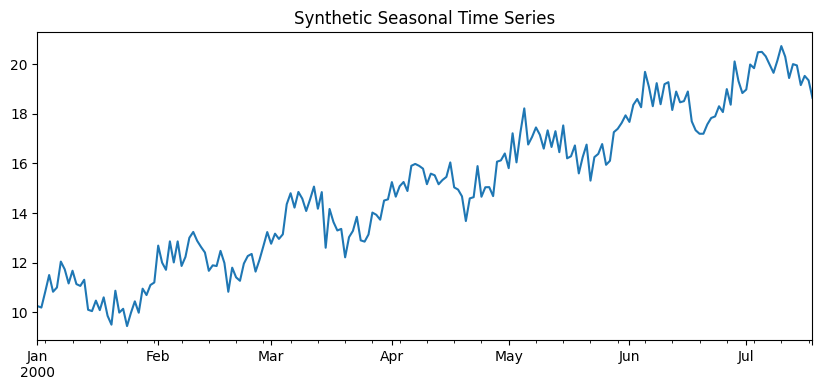

In [613]:
# Set a seed for reproducibility
np.random.seed(42)

# Create a time index
n_points = 200
time_index = pd.date_range(start='2000-01-01', periods=n_points, freq='D')

# Generate a seasonal pattern (sine wave)
seasonality_period = 30
offset = 10
seasonal_pattern = np.sin(2 * np.pi * np.arange(n_points) / seasonality_period)

# Add some trend (e.g., linear upward trend)
trend = 0.05 * np.arange(n_points)

# Add random noise
noise = np.random.normal(loc=0.0, scale=0.5, size=n_points)

# Combine these components
data = offset + trend + seasonal_pattern + noise

# Create a Pandas Series
df = pd.Series(data, index=time_index, name='value')

# Plot the series
df.plot(title='Synthetic Seasonal Time Series', figsize=(10, 4))
plt.show()

#print(df.head())

In [614]:
# Perform Augmented Dickey-Fuller test
adf_result = adfuller(df)

# Print the result of the ADF test
#print("ADF Statistic:", adf_result[0])
#print("p-value:", adf_result[1])
#print("Used Lag:", adf_result[2])
#print("Number of Observations Used:", adf_result[3])
#print("Critical Values:", adf_result[4])
print("Conclusion: The series is stationary" if adf_result[1] < 0.05 else "Conclusion: The series is non-stationary")

Conclusion: The series is non-stationary


In [615]:
# Find the number of differences (d) needed to make the series stationary
ndiffs_value = ndiffs(df)

# Print the result
print(f"Optimal number of differences (d): {ndiffs_value}")

Optimal number of differences (d): 1


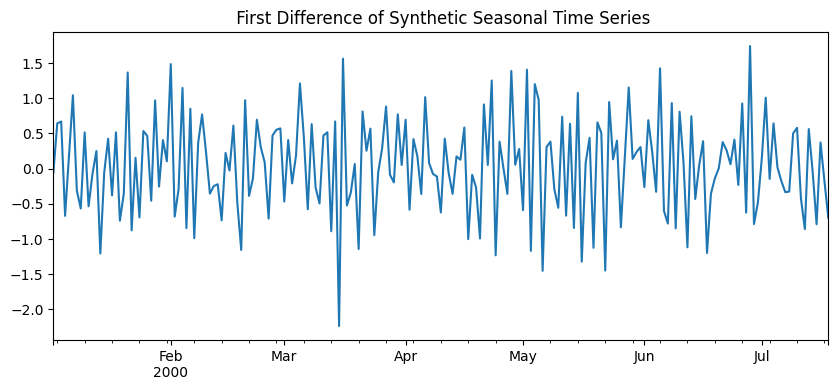

In [616]:
df_diffed = difference(df)

df_diffed.plot(title=' First Difference of Synthetic Seasonal Time Series', figsize=(10, 4))
plt.show()

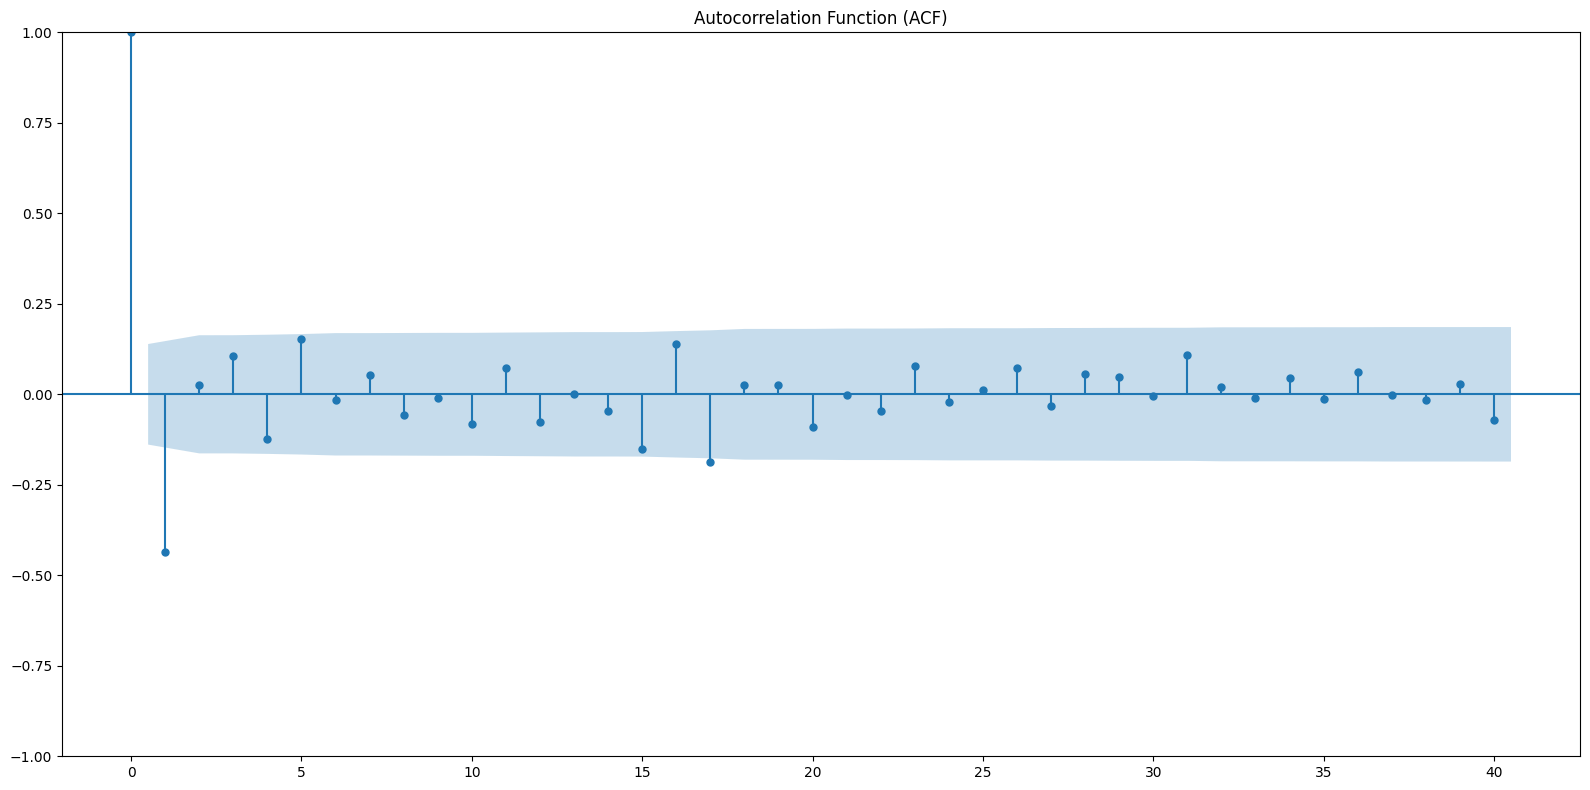

Significant ACF lags:
[1, 17]


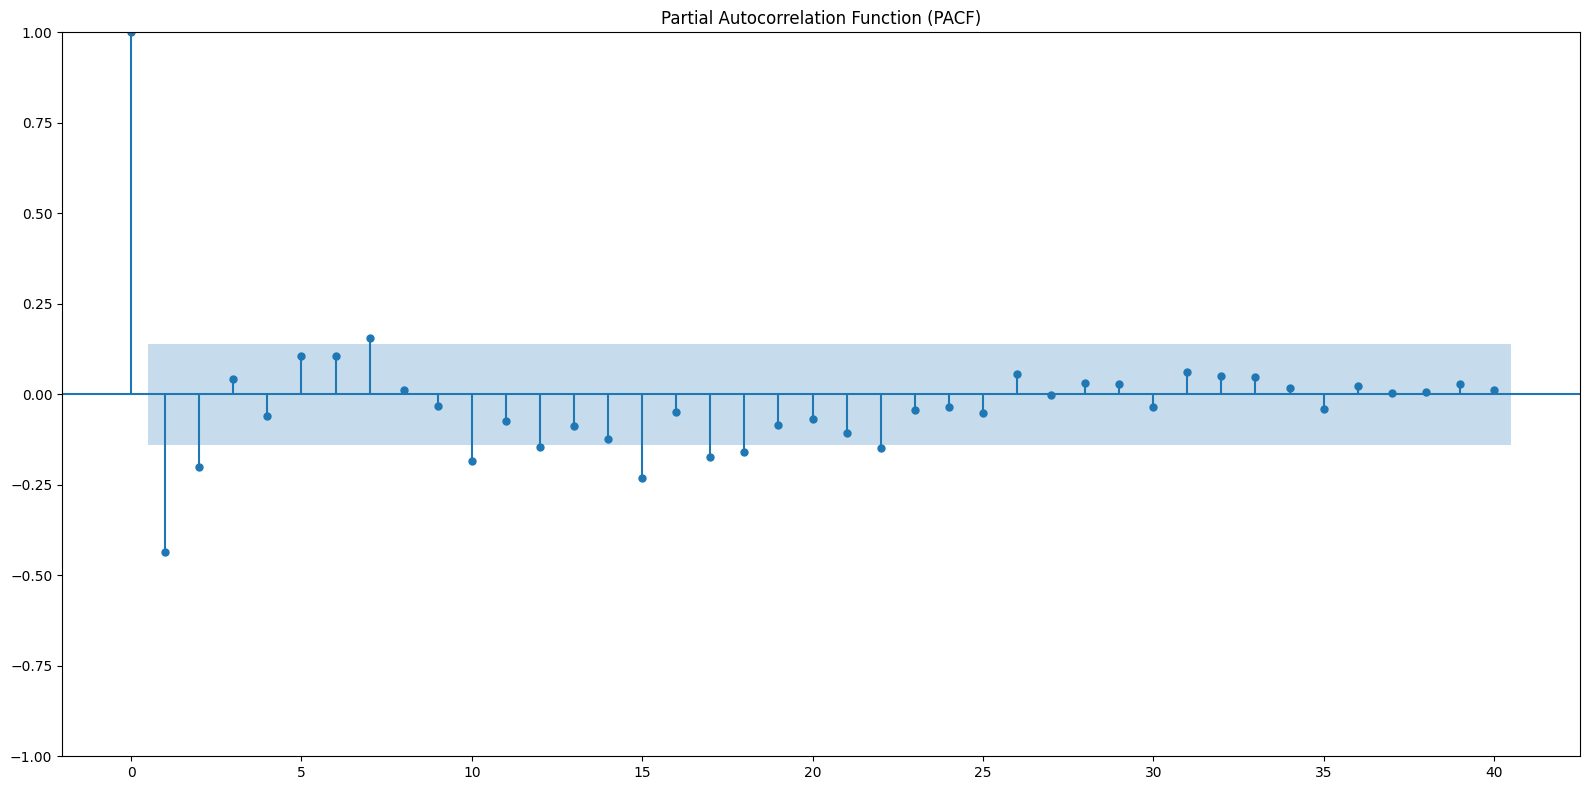

Significant PACF lags:
[1, 2, 7, 10, 12, 15, 17, 18, 21, 22, 25]


In [617]:
# Create a figure with 2 subplots (one for the price and one for the ACF)
#fig, axes = plt.subplots(1, 2, figsize=(15, 6))
fig, ax = plt.subplots(figsize=(16, 8))
# Plot the ACF for the 'PRC' column (on the second subplot)
plot_acf(df_diffed.dropna(), lags=40, ax=ax)
ax.set_title('Autocorrelation Function (ACF)')
plt.tight_layout()
plt.show()
ax.set_title('Autocorrelation Function (ACF) of the First Difference')

# Print the significant lags
q = get_significant_acf_lags(df_diffed)
print("Significant ACF lags:")
print(q)

# Create a figure with 2 subplots (one for the price and one for the ACF)
#fig, axes = plt.subplots(1, 2, figsize=(15, 6))
fig, ax = plt.subplots(figsize=(16, 8))
# Plot the ACF for the 'PRC' column (on the second subplot)
plot_pacf(df_diffed.dropna(), lags=40, ax=ax)
ax.set_title('Partial Autocorrelation Function (PACF)')
plt.tight_layout()
plt.show()
ax.set_title('Partial Autocorrelation Function (PACF) of the First Difference')

# Print the significant lags
p = get_significant_pacf_lags(df_diffed)

print("Significant PACF lags:")
print(p)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]
[1, 17]
2000-07-19    19.009133
2000-07-20    19.145568
2000-07-21    19.358369
2000-07-22    19.549776
2000-07-23    19.282020
                ...    
2000-10-22    24.105510
2000-10-23    24.291655
2000-10-24    24.530089
2000-10-25    24.764971
2000-10-26    24.998582
Freq: D, Name: Forecast, Length: 100, dtype: float64


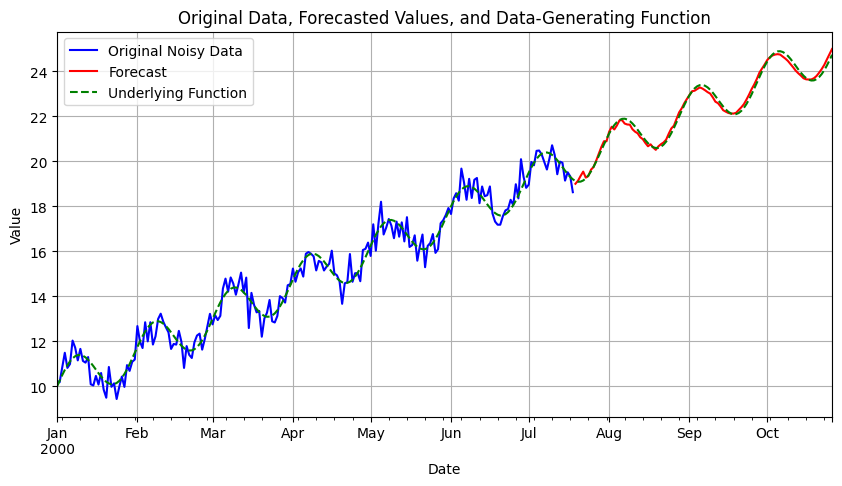

In [618]:
p = list(range(1,26))
#q = list(range(1,18))

print(p)
print(q)

model = ARIMA(p=p, i=1, q=q, df=df)
preds = forecast(model, steps=100)

# Get the last timestamp from the original series
last_date = df.index[-1]

# Create a datetime index for the forecast period
future_dates = pd.date_range(start=last_date + pd.Timedelta('1D'), periods=len(preds), freq='D')

# Convert the predictions to a pandas Series
pred_series = pd.Series(preds, index=future_dates, name='Forecast')
print(pred_series)

# ---------------------------------------------------------
# Plot the underlying function (the deterministic part without noise)
# We know the original generation parameters (from previous context).
# Recreate them for the entire period + forecast:

original_length = len(df)
forecast_length = len(preds)
extended_length = original_length + forecast_length

extended_index = pd.date_range(start=df.index[0], periods=extended_length, freq='D')

underlying_seasonal = np.sin(2 * np.pi * np.arange(extended_length) / seasonality_period)
trend = 0.05 * np.arange(extended_length)
underlying_pattern = offset + trend + underlying_seasonal

underlying_series = pd.Series(underlying_pattern, index=extended_index, name='Underlying Function')

# ---------------------------------------------------------
# Plot all three: original data, forecast, and underlying function

fig, ax = plt.subplots(figsize=(10, 5))
df.plot(ax=ax, label='Original Noisy Data', color='blue')
pred_series.plot(ax=ax, label='Forecast', color='red')
underlying_series.plot(ax=ax, label='Underlying Function', color='green', linestyle='--')

plt.title("Original Data, Forecasted Values, and Data-Generating Function")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()
